# TAREA 2: detección de objetos para el Reconocimiento de Montos

**Profesor de Cátedra:** José M. Saavedra.

**Profesor Auxiliar:** Cristóbal Loyola (cloyola@dcc.uchile.cl)

**INTEGRANTES:**


*   Paula Canales
*   Alvaro Neira


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Para copiar el zip desde tu Google Drive, debes crear la carpeta t2-data en la raíz de tu Drive. En dicha carpeta debe existir el zip mencionado.

In [2]:
# Copiamos los datos al entorno de Colab
!mkdir -p /content/data
%cd /content/data
!cp /content/drive/MyDrive/t2-data/orand-car-with-bbs.zip .
!unzip -q -o orand-car-with-bbs.zip
!rm orand-car-with-bbs.zip

/content/data


## YOLOv5

La implementación de este modelo se puede encontrar en el siguiente repositorio: https://github.com/ultralytics/yolov5 (para más información, ir [aquí](https://towardsai.net/p/computer-vision/yolo-v5%E2%80%8A-%E2%80%8Aexplained-and-demystified)). Para llevar a cabo el entrenamiento sobre un dataset personalizado, pueden seguir este tutorial: https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data. Los pasos más relevantes son crear un archivo de configuración que contenga la ruta de las imágenes, la cantidad de clases y los nombres de las categorías. Además, debemos convertir las coordenadas de las anotaciones desde el formato [class_idx, xmin, ymin, width, height] que viene con el dataset a un formato [class_idx, x_center, y_center, width, height], donde las coordenadas están normalizadas por el tamaño de la imagen. El resto del proceso se puede llevar a cabo tal como se indica en el tutorial y en el README del repositorio. Para modificar los parámetros de detección, pueden revisar los argumentos del archivo *detect.py* (incluye la opción de NMS).

### Convertir coordenadas

El primer paso será convertir el formato de las anotaciones como se mencionó anteriormente. El código requiere tener las imágenes en un directorio llamado 'images' y las anotaciones en un directorio llamado 'labels'.


In [3]:
%cd /content/data/orand-car-with-bbs/training
!mkdir labels

import cv2
import glob
import os

filenames = glob.glob("./annotations/*.txt")

# Iteramos sobre todas las imágenes
for filename in filenames:

    # Abrimos la imagen para obtener sus dimensiones
    img_path = filename.split("/")[-1].replace(".txt", ".png")
    img_path = os.path.join("./images", img_path)
    img = cv2.imread(img_path)
    img_height, img_width, _ = img.shape

    # Obtenemos las coordenadas de cada objeto en la imagen
    with open(filename, 'r') as f:
        lines = f.readlines()
        lines = [x.strip() for x in lines]
        lines = [x.replace(' ', '') for x in lines]

    annotations_yolo = []
    # Iteramos sobre todas las anotaciones de la imagen
    for obj in lines:
        label = obj.split(":")[0]
        bbox = obj.split(":")[1]
        bbox = bbox.replace(",", " ")

        annotation = label + " " + bbox
        ann = annotation.split(" ")
        ann = [int(x) for x in ann]
        label = ann[0]
        xmin, ymin, width, height = ann[1:]

        # Obtenemos las coordenadas normalizadas
        x_center = (xmin + (width / 2)) / img_width
        y_center = (ymin + (height/ 2)) / img_height
        width = width / img_width
        height = height / img_height

        obj_info = [label, x_center, y_center, width, height]
        annotations_yolo.append(obj_info)

    # Escribimos las nuevas anotaciones en un archivo del mismo nombre pero 
    # en el directorio labels
    new_filename = filename.split("/")[-1]
    new_filename = os.path.join("./labels", new_filename)
    with open(new_filename, mode='w') as outfile:
        for annotation in annotations_yolo:
            annotation = [str(x) for x in annotation]
            line = ' '.join(annotation)
            outfile.write("%s\n" % line)

/content/data/orand-car-with-bbs/training


In [4]:
# Ejemplo de anotación antigua
!cat /content/data/orand-car-with-bbs/training/annotations/0001_5179655_46066.txt

4: 83, 8, 43, 53
6: 143, 11, 39, 50
0: 204, 11, 43, 43
6: 264, 15, 43, 43
6: 329, 11, 36, 51

In [5]:
# Ejemplo de la misma anotación pero con el nuevo formato
!cat /content/data/orand-car-with-bbs/training/labels/0001_5179655_46066.txt

4 0.2301762114537445 0.4928571428571429 0.0947136563876652 0.7571428571428571
6 0.3579295154185022 0.5142857142857142 0.08590308370044053 0.7142857142857143
0 0.4966960352422907 0.4642857142857143 0.0947136563876652 0.6142857142857143
6 0.6288546255506607 0.5214285714285715 0.0947136563876652 0.6142857142857143
6 0.76431718061674 0.5214285714285715 0.07929515418502203 0.7285714285714285


Ahora dividiremos los datos en un conjunto de entrenamiento y uno de test, en una proporción 90%-10% respectivamente.

In [6]:
%cd /content/data/orand-car-with-bbs/training

import numpy as np
import random

filenames = glob.glob("images/*.png")
random.shuffle(filenames)

n = len(filenames)
split_ratio = 0.9
split_index = np.rint(n * split_ratio).astype("int")

train_split = filenames[:split_index]
test_split = filenames[split_index:]

train_dir = "/content/data/orand-car-with-bbs/training/"

with open("train.txt", mode='w') as outfile:
    for annotation in train_split:
        annotation = os.path.join(train_dir, annotation)
        outfile.write("%s\n" % annotation)

with open("test.txt", mode='w') as outfile:
    for annotation in test_split:
        annotation = os.path.join(train_dir, annotation)
        outfile.write("%s\n" % annotation)

print(f"Total de imágenes: {n}")
print(f"Imágenes de entrenamiento: {len(train_split)}")
print(f"Imágenes de test: {len(test_split)}")

/content/data/orand-car-with-bbs/training
Total de imágenes: 6506
Imágenes de entrenamiento: 5855
Imágenes de test: 651


### Entrenamiento

Para el entrenamiento seguiremos los siguientes pasos:

* Clonar el repositorio de YOLOv5.
* Instalar las librerías requeridas.
* Modificar los archivos de configuración necesarios.

In [7]:
# Clonamos el repositorio
%cd /content
!rm -rf yolov5
!git clone https://github.com/ultralytics/yolov5

# Instalamos los requisitos
%cd /content/yolov5
!pip install -r requirements.txt

/content
Cloning into 'yolov5'...
remote: Enumerating objects: 10013, done.
remote: Total 10013 (delta 0), reused 0 (delta 0), pack-reused 10013
Receiving objects: 100% (10013/10013), 10.35 MiB | 30.72 MiB/s, done.
Resolving deltas: 100% (6944/6944), done.
/content/yolov5
     |████████████████████████████████| 596 kB 5.1 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Ahora agregaremos el siguiente archivo de configuración en el directorio ```/content/yolov5/data```, con el nombre *digits.yaml*:



```
train: /content/data/orand-car-with-bbs/training/train.txt
val: /content/data/orand-car-with-bbs/training/test.txt

# number of classes
nc: 10

# class names
names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
```



## Entrenamiento

* Descomentar para entrenar
* Con 10 épocas demora 23 minutos aproximadamente
* Con 20 épocas demora 45 minutos aproximadamente

In [8]:
# Entrenamos el modelo
#%cd /content/yolov5
#!python train.py --img 640 --batch 16 --epochs 10 --data digits.yaml --weights yolov5s.pt

In [9]:
# Guarda resultados en drive
# !mkdir -p /content/drive/MyDrive/t2-train
# !rm -rf /content/drive/MyDrive/t2-train/*
# !cp -r /content/yolov5/runs/train /content/drive/MyDrive/t2-train/

In [10]:
# Restaura resultados en yolo
!mkdir -p /content/yolov5/runs/
!cp -r /content/drive/MyDrive/t2-train/train /content/yolov5/runs/

### Testing

In [11]:
!rm -rf  /content/yolov5/runs/detect

In [12]:
# %cd /content/yolov5
!python detect.py --source /content/data/orand-car-with-bbs/test/images --weights runs/train/exp/weights/best.pt --conf-thres 0.5 --iou-thres 0.1 --save-txt

detect: weights=['runs/train/exp/weights/best.pt'], source=/content/data/orand-car-with-bbs/test/images, imgsz=[640, 640], conf_thres=0.5, iou_thres=0.1, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-104-g4ca4aec torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 213 layers, 7037095 parameters, 0 gradients, 15.9 GFLOPs
image 1/463 /content/data/orand-car-with-bbs/test/images/handwritten_MX8900201925091235157_oQ4HtfShcU-BqOSjyAJ6Zg.bmp: 192x640 3 0s, 1 6, 1 8, Done. (0.016s)
image 2/463 /content/data/orand-car-with-bbs/test/images/handwritten_MX8900201925091339247_k7Mofitc_EuA-kzxGZSyfQ.bmp: 128x640 4 0s, 1 2, 1 3, 1 4, Done. (0.019s)
image 3/463 /content/data/orand-car-with-bb

In [13]:
# !mkdir -p /content/drive/MyDrive/t2-detect
# !rm -rf /content/drive/MyDrive/t2-detect/*
# !cp -r /content/yolov5/runs/detect /content/drive/MyDrive/t2-detect/

In [14]:
# Restaurar datos detectados (~6 minutos)
!cp -r /content/drive/MyDrive/t2-detect/detect/ /content/yolov5/runs/

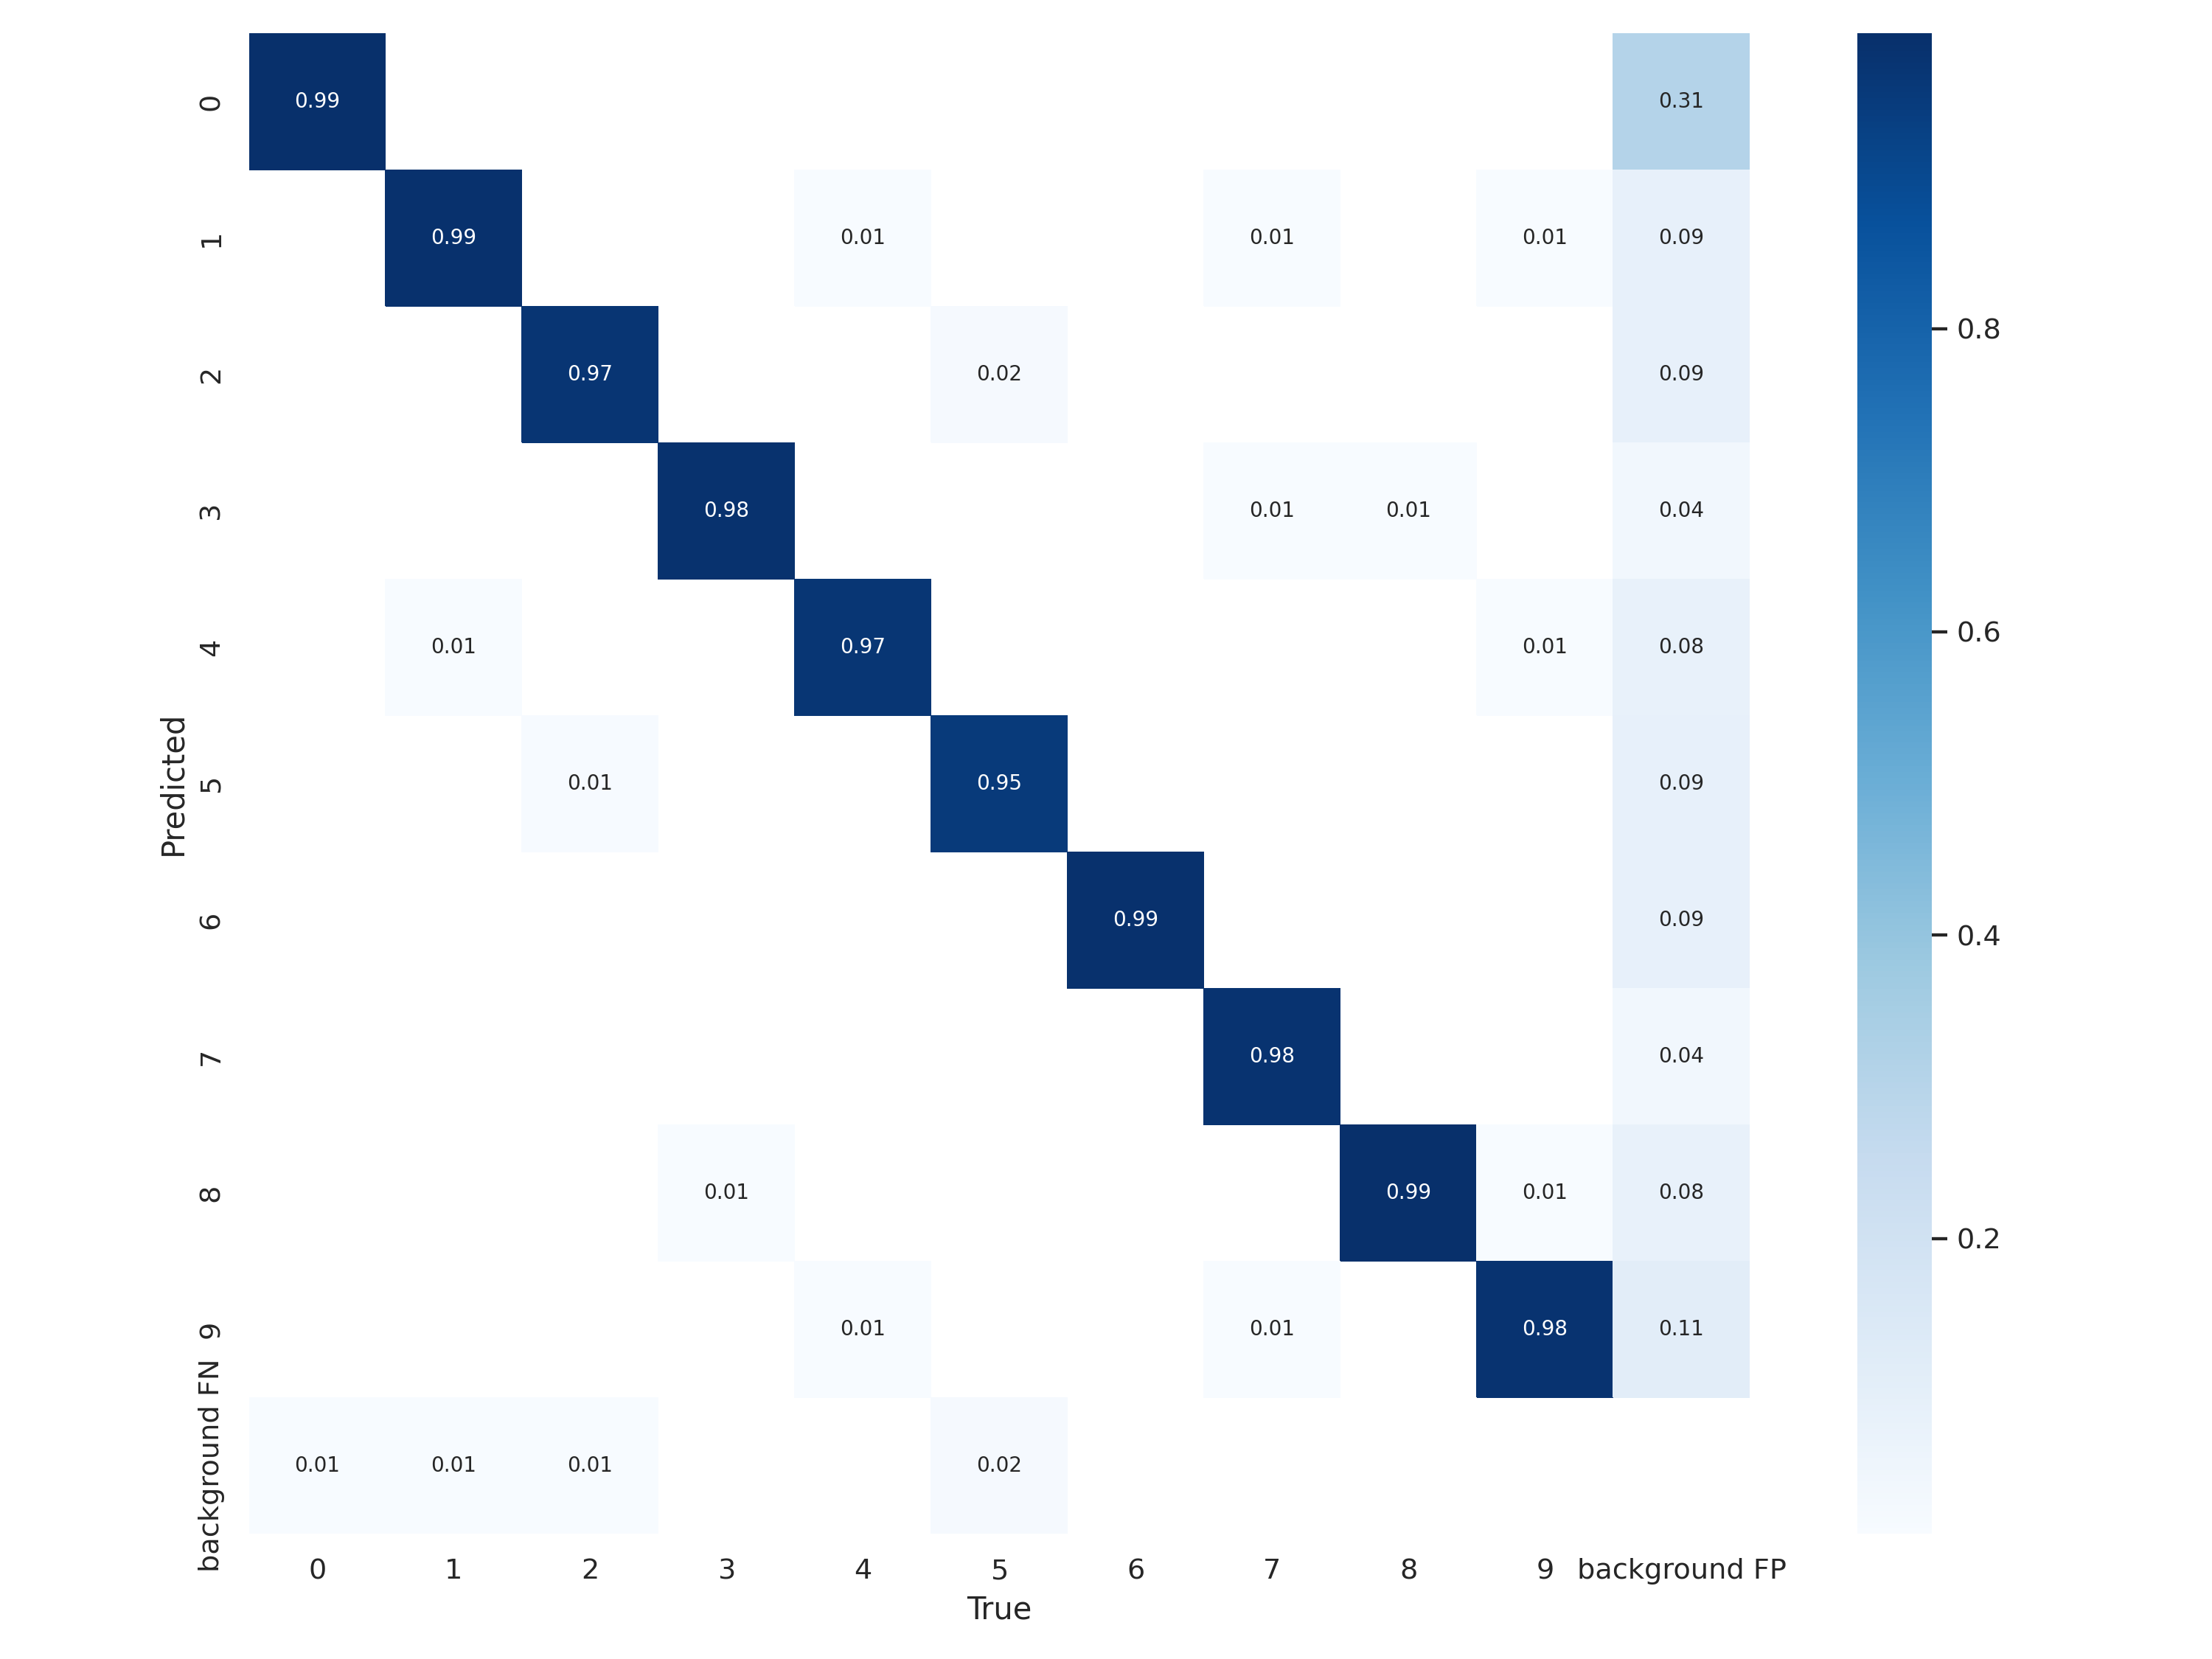

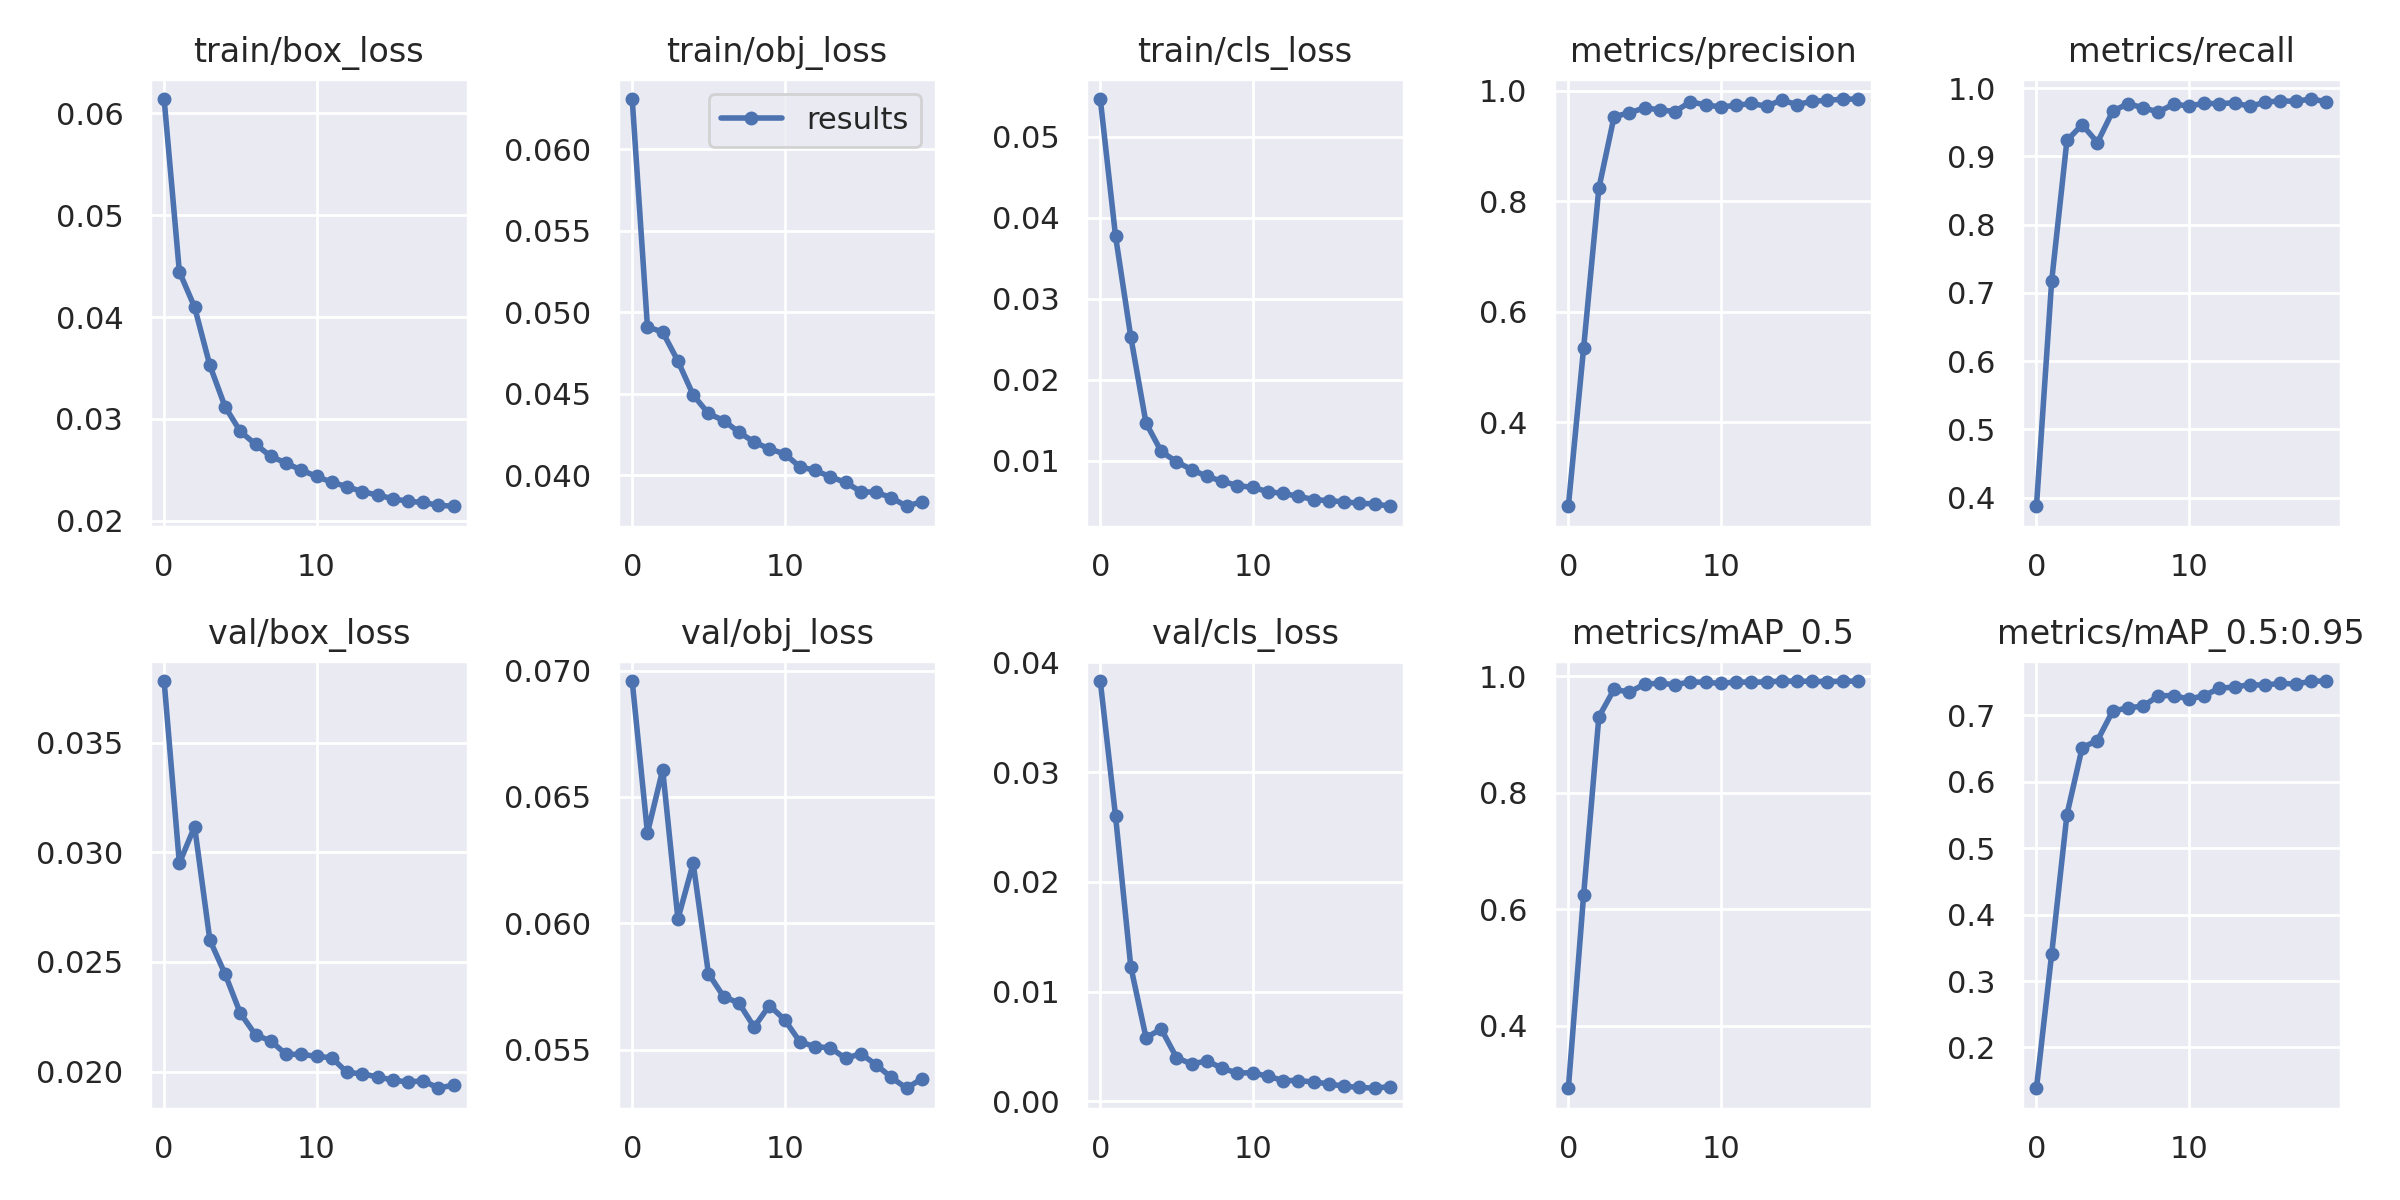

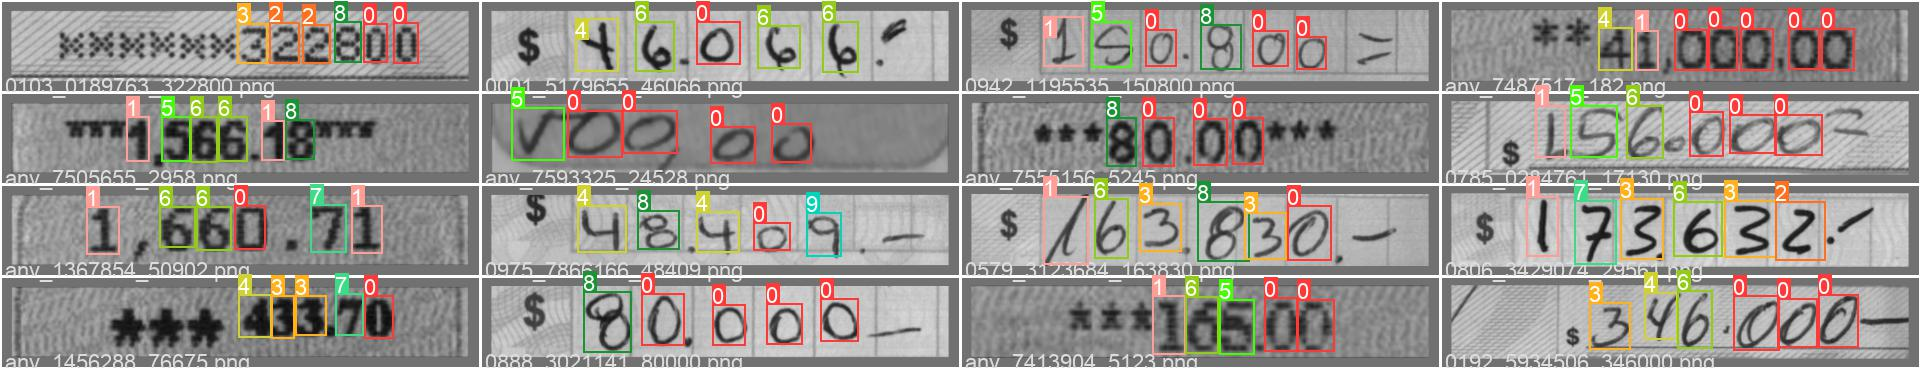

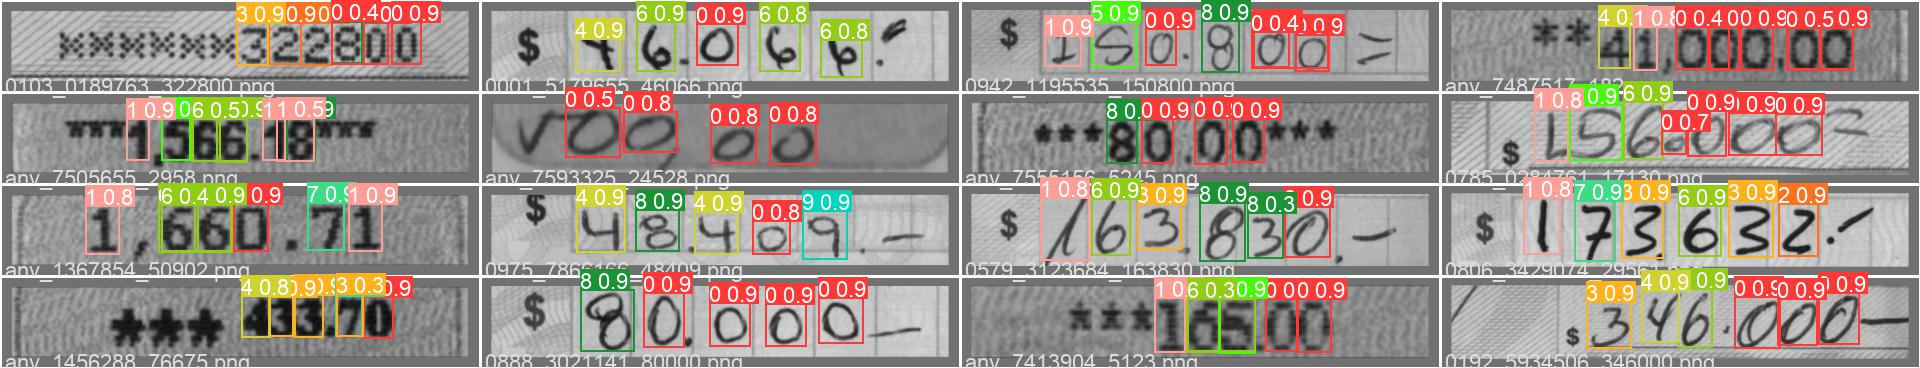

In [15]:
from IPython.display import Image, display

display(Image('/content/yolov5/runs/train/exp/confusion_matrix.png'))
display(Image('/content/yolov5/runs/train/exp/results.png'))
display(Image('/content/yolov5/runs/train/exp/val_batch2_labels.jpg'))
display(Image('/content/yolov5/runs/train/exp/val_batch2_pred.jpg'))

# Cálculo de accuracy conjunto de test

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import glob

## Pruebas

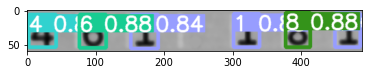

In [17]:
img = cv2.imread("/content/yolov5/runs/detect/exp/handwritten_MX8900201925093637024_maEnO1gFYEWnCyVkm4IPuQ.bmp")
plt.imshow(img)

In [18]:
!cat /content/yolov5/runs/detect/exp/labels/handwritten_MX8900201925093637024_maEnO1gFYEWnCyVkm4IPuQ.txt


1 0.654397 0.491525 0.0777096 0.813559
1 0.349693 0.516949 0.0817996 0.830508
4 0.0449898 0.5 0.0817996 0.79661
1 0.956033 0.483051 0.0756646 0.830508
8 0.807771 0.474576 0.0736196 0.847458
6 0.195297 0.508475 0.0797546 0.813559


In [19]:
#ordenando los objetos encontrados de izquierda a derecha (por ejemplo, 
#en base a la coordenada x de la esquina superior izquierda del bounding box, o a la coordenada x del centro).
data = pd.read_csv('/content/yolov5/runs/detect/exp/labels/handwritten_MX8900201925093637024_maEnO1gFYEWnCyVkm4IPuQ.txt', header = None, sep=" ")
data = data.sort_values(by=1)
values = data[0].values.tolist()
int(''.join(str(val) for val in values))

461181

## Cálculo total

In [20]:
!cp /content/data/orand-car-with-bbs/test/list.txt /content/yolov5/runs/list.txt

In [21]:
class Metrics:
  def __init__(self):
    self.positives = []
    self.negatives = []
    self.accuracy = 0

  def calculate_accuracy(self):

      # Definición de los archivos de detección a recorrer
      data_dir = "/content/yolov5/runs/detect/exp/labels/"
      labels_files = glob.glob(data_dir + "*.txt")

      # Las etiquetas reales se llevan a DataFrame
      real = pd.read_csv('/content/yolov5/runs/list.txt', header = None, sep="\t")

      # Contadores para cálculo de métricas
      n_positive = 0
      n_negative = 0
      n_total = len(labels_files)

      # Iteramos sobre los archivos de detección
      for idx, label_file in enumerate(labels_files):

        # Se obtiene el nombre del archivo txt y su imagen correspondiente
        name_file = label_file.split('/')[7]
        img_file = name_file.replace('.txt', '.bmp')

        # Se obtiene el valor detectado en el archivo utilizando DataFrame
        # ordenando los dígitos encontrados en base a la coordenada x
        data = pd.read_csv(data_dir+name_file, header = None, sep=" ")
        data = data.sort_values(by=1)

        # Se concatenan los dígitos para obtener el valor final
        values = data[0].values.tolist()
        amount = int(''.join(str(val) for val in values))

        # Se obtiene el valor real del archivo
        real_amount = (real.loc[real[0] == img_file])[1].values[0]

        record = {
            'file': img_file,
            'real': real_amount,
            'detected': amount,
        }
        
        # Se compara el monto detectado con el monto real
        if (amount == real_amount ):
          self.positives.append(record)
          n_positive += 1
        else:
          self.negatives.append(record)
          n_negative += 1

        # Se imprime información
        log = """
          ---- Calculating File {} ----
          detected amount: {}
          real amount:     {}
          positive:        {}
          -----------------------------
          """.format(
              name_file,
              amount,
              real_amount,
              amount == real_amount
          )
        print(log)

      # Se calcula el accuracy
      self.accuracy = n_positive / n_total

      # Muestra resultados
      result = {
          'n_positive: ': n_positive,
          'n_negative: ': n_negative,
          'n_total: ': n_total,
          'accuracy': self.accuracy
      }
      print(result)

  def show_negative_results(self):
    data_test_dir = "/content/data/orand-car-with-bbs/test/images/"
    fig = plt.figure(figsize=(20, 40))
    n_negatives = len(self.negatives)
    columns = 5
    rows = (n_negatives // columns) + 1
    position = 1

    for img in self.negatives:
      image = cv2.imread(data_test_dir+img['file'])
      title = "real: {} \n detected: {}".format(img['real'], img['detected'])
      fig.add_subplot(rows, columns, position)
      plt.imshow(image)
      plt.axis('off')
      plt.title(title)
      position += 1

  def show_negative_posible_iou(self):
    data_test_dir = "/content/data/orand-car-with-bbs/test/images/"
    fig = plt.figure(figsize=(20, 40))
    n_negatives = len(self.negatives)
    columns = 5
    rows = (n_negatives // columns) + 1
    position = 1

    for img in self.negatives:
      if len(str(img['real'])) < len(str(img['detected'])):
        image = cv2.imread(data_test_dir+img['file'])
        title = "real: {} \n detected: {}".format(img['real'], img['detected'])
        fig.add_subplot(rows, columns, position)
        plt.imshow(image)
        plt.axis('off')
        plt.title(title)
        position += 1


In [22]:
m = Metrics()
m.calculate_accuracy()


          ---- Calculating File handwritten_MX8900201936133132557_P_clcBHP50SCxcCzl4n-Lg.txt ----
          detected amount: 90000
          real amount:     90000
          positive:        True
          -----------------------------
          

          ---- Calculating File handwritten_MX8900201936123530080_zRIHXkBSxUm4HfPgQq8UGA.txt ----
          detected amount: 862500
          real amount:     862500
          positive:        True
          -----------------------------
          

          ---- Calculating File handwritten_MX8900201930125010467_uRZ4dZc2RkWC7dcuXUQttQ.txt ----
          detected amount: 215935
          real amount:     215935
          positive:        True
          -----------------------------
          

          ---- Calculating File handwritten_MX8900201932092508690_MnmErSBXQkWoabYszKJLYw.txt ----
          detected amount: 152727
          real amount:     152727
          positive:        True
          -----------------------------
          

 

**Se obtiene un 85,96% de accuracy**

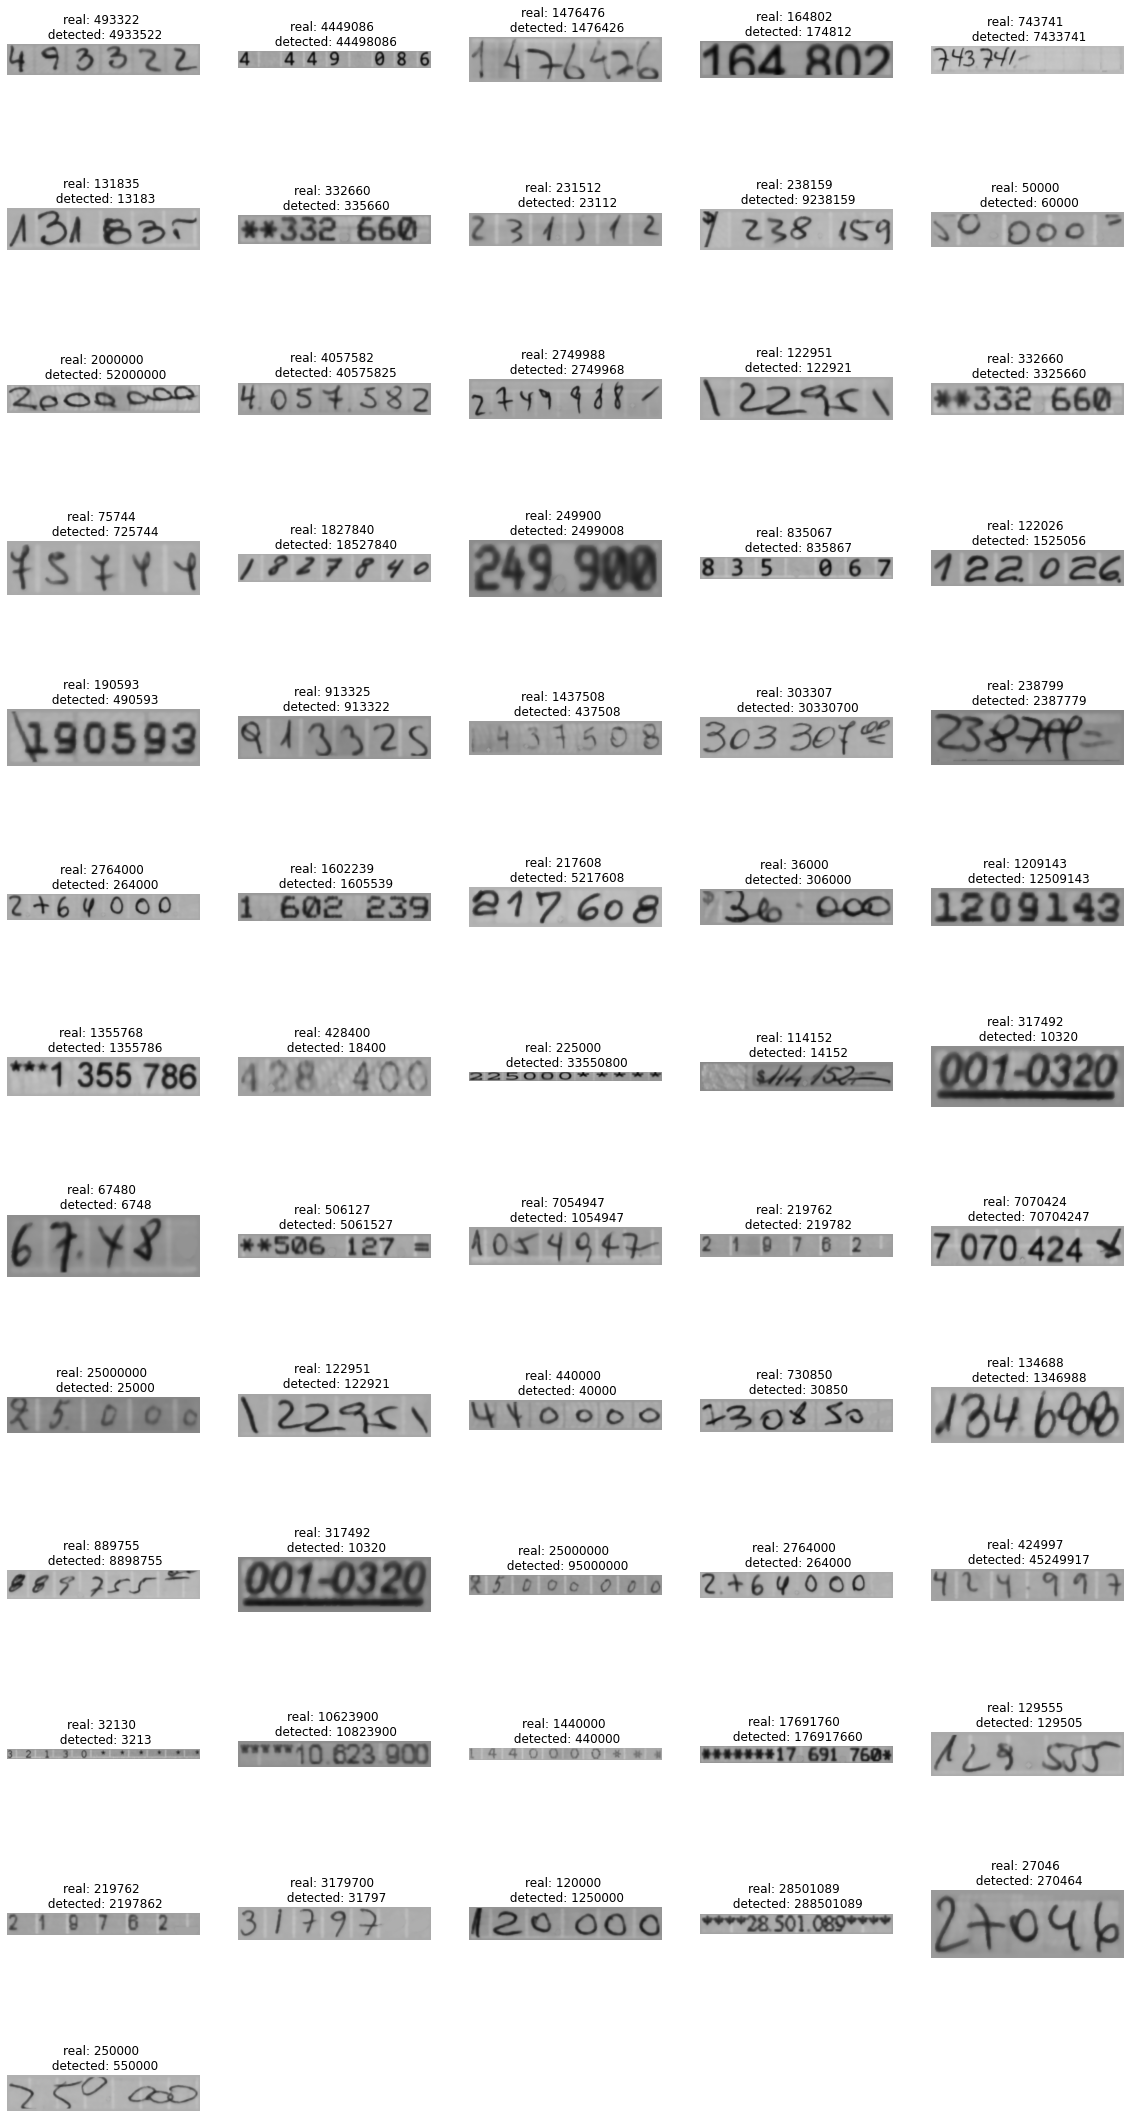

In [23]:
m.show_negative_results()

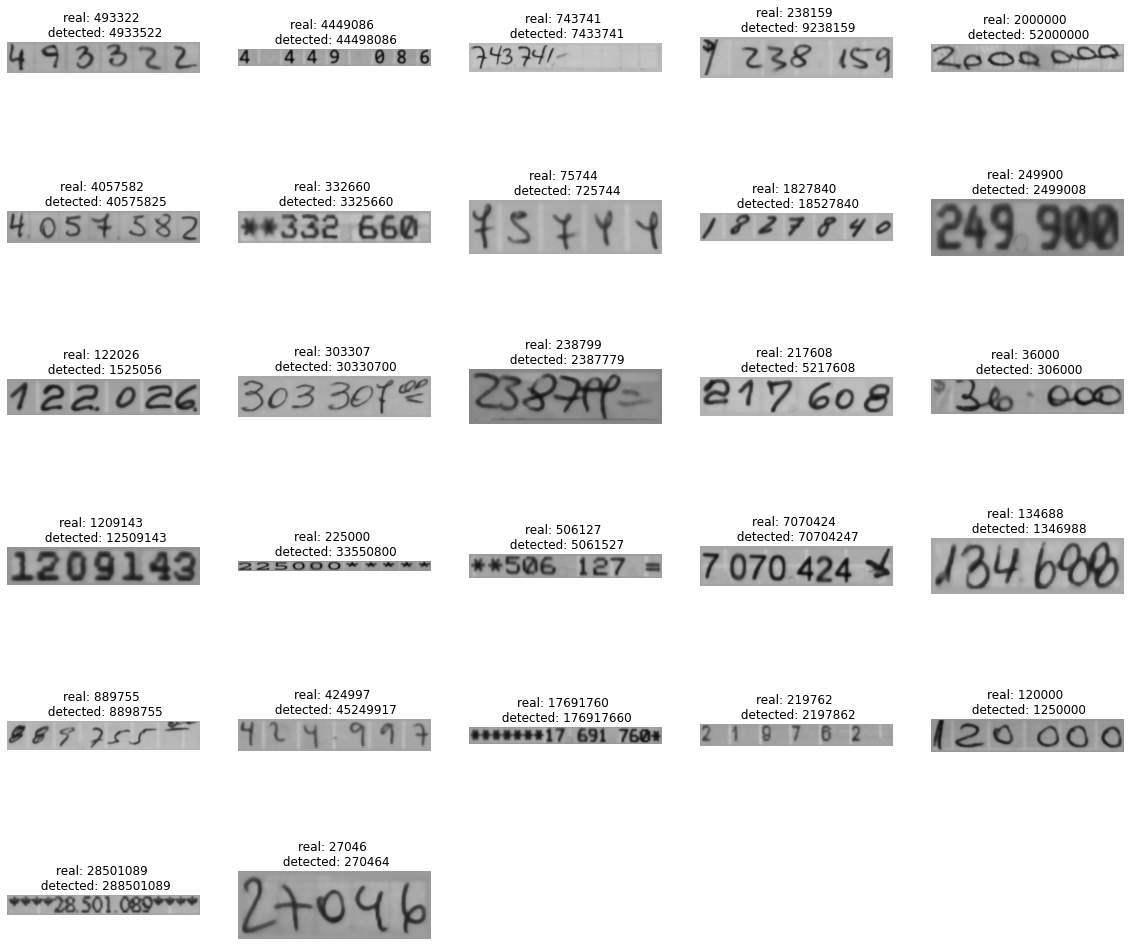

In [24]:
m.show_negative_posible_iou()

In [25]:
for f in m.negatives:
  if len(str(f['real'])) < len(str(f['detected'])):
    filetxt = "/content/yolov5/runs/detect/exp/labels/{}".format(
        f['file'].replace('bmp', 'txt')
    )
    print('----------')
    print(filetxt)
    !cat $filetxt
    print('----------')
# !cat '/content/yolov5/runs/detect/exp/labels/handwritten_MX8900201938132003550_wbg5cTb9aUGCK5pnfms0tw.txt'

----------
/content/yolov5/runs/detect/exp/labels/handwritten_MX8900201939115104871_ytftG0GoMkSzJGuJAV_DJg.txt
5 0.74125 0.507692 0.1325 0.830769
2 0.74125 0.5 0.1325 0.815385
3 0.3975 0.492308 0.11 0.8
4 0.0525 0.476923 0.095 0.892308
2 0.91625 0.5 0.1375 0.815385
9 0.22625 0.469231 0.1125 0.784615
3 0.56875 0.446154 0.1175 0.8
----------
----------
/content/yolov5/runs/detect/exp/labels/handwritten_MX8900201929095424067_OHhz3QntskmytsSDYRaLQw.txt
8 0.734694 0.464912 0.0596546 0.859649
0 0.734694 0.45614 0.0596546 0.877193
4 0.033752 0.464912 0.0612245 0.859649
4 0.266876 0.45614 0.0627944 0.842105
4 0.38383 0.45614 0.0612245 0.842105
8 0.847724 0.464912 0.0565149 0.859649
9 0.497645 0.464912 0.0596546 0.859649
6 0.967033 0.464912 0.0565149 0.859649
----------
----------
/content/yolov5/runs/detect/exp/labels/handwritten_MX8900201930124446496_OF4dTiapZkum6pN5A6bElA.txt
3 0.161017 0.407143 0.118644 0.671429
1 0.420551 0.4 0.0529661 0.6
4 0.363347 0.392857 0.0783898 0.728571
4 0.136653 

In [26]:
# PODRÍAN SER POSITIVOS SI NO FUERA POR EL SOLAPE

# handwritten_MX8900201938132003550_wbg5cTb9aUGCK5pnfms0tw
# 20200
# [52]0200

# handwritten_MX8900201932101910581_v9hwFzXh0E2vfxN4STOR3A
# 2000000
# [25]000000

# handwritten_MX8900201937125045584_nDYTcXM_fUCujaVQB3QX8A
# 4057582
# 405758[52]

# handwritten_MX8900201931132352716_r36EzEiMnEyVeCjjtrRJZA
# 522825
# 52282[52]

# handwritten_MX8900201930125348217_7IsBBHsTvUSUK1kmfCRDJg
# 122951
# 1229[25]1

# handwritten_MX8900201935125436244_BpUdBplAPkirVQqVpKRCZw
# 913325
# 91332[25]

# handwritten_MX8900201942132157920_YSOVCz1ykU2rWtn4Yrh7qQ
# 120000
# 1[52]0000

# handwritten_MX8900201936104541029_5QR1yR0co0-O9tzxsqFurw
# 21215274
# 21215[52]74

# handwritten_MX8900201936105052243_TwipLQA7rEu-bPu-d3iLAA
# 249900
# [25]49900